# Recommended Joke Notebook

Today, we'll use some joke rating data to check out recommendating systems, in particular collaborative filtering:

Here's a link to the place where I got the data:
http://goldberg.berkeley.edu/jester-data/

Check out some jokes, and get recommended jokes based on your ratings:
http://eigentaste.berkeley.edu/

In [62]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

### Load the Data

- Each row is a user
- The first column is the total number of jokes rated by that user.
- The remaining columns are the ratings of the individual jokes, from -10 to 10
- An entry of 99 means no rating.

In [69]:
data = pd.read_csv('jester_data.csv', header=None).values
data[data==99] = 0
number_rated = data[:, 0]
ratings = data[:, 1:]
ratings[:5,:5]

array([[-7.82,  8.79, -9.66, -8.16, -7.52],
       [ 4.08, -0.29,  6.36,  4.37, -2.38],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  9.03],
       [ 0.  ,  8.35,  0.  ,  0.  ,  1.8 ],
       [ 8.5 ,  4.61, -4.17, -5.39,  1.36]])

In [68]:
ratings.shape

(73421, 100)

# Do some EDA on the data

How many jokes does an average person rate? What is most jokes rated? What is the fewest number of jokes rated?

How many ratings on average does each joke have?

What is a joke with the most ratings? Which is one with the fewest ratings?

What is the average rating for all jokes? (Be sure to exclude the 0 values!)

In [70]:
print "Average number of jokes rated: ", number_rated.mean()
print "Most jokes rated by a user: ", number_rated.max()
print "Fewest jokes rated by a user: ", number_rated.min()

joke_has_rating = (ratings != 0)
n_joke_ratings = np.sum(joke_has_rating, 0)

print "No. ratings per joke: ", n_joke_ratings.mean()
print "A most rated joke index: ", np.argmax(n_joke_ratings), " with ", n_joke_ratings.max(), "ratings"
print "Least rated joke index: ", np.argmin(n_joke_ratings), " with ", n_joke_ratings.min(), "ratings"

print "Average rating for all jokes: ", (data[:, 1:][data[:, 1:]!=0]).mean()

Average number of jokes rated:  56.1177728443
Most jokes rated by a user:  100.0
Fewest jokes rated by a user:  0.0
No. ratings per joke:  41237.56
A most rated joke index:  15  with  73222 ratings
Least rated joke index:  70  with  18466 ratings
Average rating for all jokes:  0.744414829587


# Unregularized SVD Based Collaborative Filtering

## step 1: full SVD

We'll do a simple though not very effective way at collaborative filtering: a simple SVD approach.

SVD (singular value decomposition) is a way of decomposing a matrix into thing like eigenvectors and eigenvalues. It looks like this for a matrix M:

M = U * S * V

Here, if we suppose M is an n by p matrix:
U is an N by p matrix
S is a p by p diagonal matrix
V is a p by p matrix

In our problem, we have n users rating p jokes

In recommender problems, it has the interpretation as follows:
U is a representation of the users, as p features
V is a representation of the jokes, as p features (different from those in U)
S is a vector that gives the joint importance of both feature sets

In [72]:
# full svd; note the first column is dropped since that has the number of jokes rated, we don't care about that
u, s, v = np.linalg.svd(ratings, full_matrices=False)

print u.shape
print s.shape
print v.shape

# these are (nearly) the same, that's the decomposition!
print data[:, 1:]
print np.dot(np.dot(u, np.diag(s)), v) # the full reconstruction

(73421, 100)
(100,)
(100, 100)
[[-7.82  8.79 -9.66 ...,  0.    0.    0.  ]
 [ 4.08 -0.29  6.36 ...,  0.34 -4.32  1.07]
 [ 0.    0.    0.   ...,  0.    0.    0.  ]
 ..., 
 [ 0.    0.    0.   ...,  0.    0.    0.  ]
 [ 0.    0.    0.   ...,  0.    0.    0.  ]
 [ 0.    0.    0.   ...,  0.    0.    0.  ]]
[[ -7.82000000e+00   8.79000000e+00  -9.66000000e+00 ...,  -3.81916720e-14
   -4.49640325e-14  -4.88498131e-14]
 [  4.08000000e+00  -2.90000000e-01   6.36000000e+00 ...,   3.40000000e-01
   -4.32000000e+00   1.07000000e+00]
 [  1.72220864e-14   2.00666511e-14   1.74712122e-14 ...,   7.10542736e-15
    4.44089210e-15  -8.88178420e-15]
 ..., 
 [  4.78143928e-16  -4.00068618e-15  -1.30492825e-14 ...,  -1.55431223e-15
   -7.93809463e-15  -2.22044605e-15]
 [  4.83791321e-15   4.75440058e-15   3.98015344e-15 ...,  -4.44089210e-15
    5.55111512e-17  -8.88178420e-16]
 [  1.28097179e-14   6.83171962e-15  -5.88573051e-16 ...,  -1.30451205e-15
    7.21644966e-15  -1.35447209e-14]]


##  Step 2: Filling in values by truncating the SVD

The SVD above just recovers the original matrix. That is not very interesting, we want to get a new estimate for those missing values. To do this, we need to drop dimensions.

Inspect S, you should see that it is sorted in decreasing order. Write code to only take the first few dimensions in each of the projections. This means simply to replace the matrix S (you will have to construct it using np.diag) with a new matrix with many of the diagonal values zeroed out.

In [73]:
n_comp = 10

# make a new s vector with only the first few values kept
s_padded = np.zeros(len(s))
s_padded[:n_comp] = s[:n_comp]

filled_in = np.dot(np.dot(u, np.diag(s_padded)), v)

You should now have an approximation to the original matrix. Take the filled in values only and compare them to the non filled in values, do this for a few users and jokes. You might find it useful to write a function to inspect a row or column. Considering doing things like:

0. Count how many values are filled in, how many were already present for that row / column
1. Compare the range of the filled in values with those not filled in within the row or column
2. Compare the mean of the filled in values with those not filled in within the row or column

In [74]:
def inspect_filled_in_joke(ii):
    print "Inspection of joke ", ii
    preds = filled_in[:, ii][ratings[:, ii] == 0]
    non_preds = ratings[:, ii][ratings[:, ii] != 0]
    
    print "This joke has ", len(non_preds), " values present, ", len(preds), " were predicted."

    print "mean of predicted values: ", preds.mean()
    print "mean of old values: ", non_preds.mean()

    print "max of predicted values: ", np.max(preds)
    print "min of predicted values: ", np.min(preds)

    print "max of old values: ", np.max(non_preds)
    print "min of old values: ", np.min(non_preds)
    
def inspect_filled_in_user(ii):
    print "Inspection of user ", ii
    preds = filled_in[ii, :][ratings[ii, :] == 0]
    non_preds = ratings[ii, :][ratings[ii, :] != 0]
    
    print "This user has ", len(non_preds), " values present, ", len(preds), " were predicted."

    print "mean of predicted values: ", preds.mean()
    print "mean of old values: ", non_preds.mean()

    print "max of predicted values: ", np.max(preds)
    print "min of predicted values: ", np.min(preds)

    print "max of old values: ", np.max(non_preds)
    print "min of old values: ", np.min(non_preds)

inspect_filled_in_joke(14)
print "\n-----\n"
inspect_filled_in_user(2)

Inspection of joke  14
This joke has  73214  values present,  207  were predicted.
mean of predicted values:  -1.42482525698
mean of old values:  -2.11804600213
max of predicted values:  5.1484448335
min of predicted values:  -8.28764882286
max of old values:  9.9
min of old values:  -9.95

-----

Inspection of user  2
This user has  49  values present,  51  were predicted.
mean of predicted values:  1.58030364762
mean of old values:  7.0993877551
max of predicted values:  4.94446436654
min of predicted values:  -1.22045527039
max of old values:  9.37
min of old values:  -7.86


## Step 3: Let's actually use this thing. 

Write a function to recommend a joke (s)he's not rated to a user who has at least one unrated joke. Use it for a few people and print the results.

Use it on all users and make a histogram of the recommendations. Compare this to a histogram of missing values (number of times a joke was not rated). Does this system recommend a joke very often? Does it make sense?

User  0  should laugh at joke  88
User  1  already rated all the jokes!
User  2  should laugh at joke  62
User  3  should laugh at joke  60
User  4  should laugh at joke  71
User  5  already rated all the jokes!
User  6  should laugh at joke  41
User  7  should laugh at joke  99
User  8  already rated all the jokes!
User  9  should laugh at joke  99
User  10  should laugh at joke  53
User  11  should laugh at joke  73
User  12  should laugh at joke  25
User  13  already rated all the jokes!
User  14  already rated all the jokes!
User  15  should laugh at joke  16
User  16  should laugh at joke  57
User  17  already rated all the jokes!
User  18  should laugh at joke  10
User  19  should laugh at joke  97
User  20  should laugh at joke  88
User  21  should laugh at joke  2
User  22  should laugh at joke  88
User  23  already rated all the jokes!
User  24  should laugh at joke  93
[88 62 60 71 41 99 99 53 73 25 16 57 10 97 88  2 88 93]
Inspection of joke  88
This joke has  20395  values 

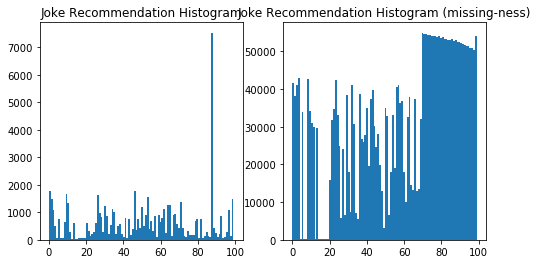

In [75]:
def recommend_to_user(ii, verbose = True):
    preds = filled_in[ii, :][ratings[ii, :] == 0]
    non_preds = ratings[ii, :][ratings[ii, :] != 0]
    
    if len(preds) > 0:
        rec = np.where([ratings[ii, :] == 0])[1][np.argmax(preds)]
        if verbose:
            print "User ", ii, " should laugh at joke ", rec
    else:
        if verbose:
            print "User ", ii, " already rated all the jokes!"
        rec = -1
    return rec

recs = []
for user_index in range(0, 25):
    recs.append(recommend_to_user(user_index))
    
recs = np.array(recs)
recs = recs[recs != -1]
print recs

recs = []
for user_index in range(data.shape[0]):
    recs.append(recommend_to_user(user_index, False))
    
recs = np.array(recs)
recs = recs[recs != -1]

not_rated_hist = []
for ii in range(ratings.shape[0]):
    for jj in range(ratings.shape[1]):
        if ratings[ii, jj] == 0:
            not_rated_hist.append(jj)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.hist(recs, np.ptp(recs) + 1)
plt.title("Joke Recommendation Histogram")
            
plt.subplot(1, 2, 2)
plt.hist(not_rated_hist, np.ptp(not_rated_hist) + 1)
plt.title("Joke Recommendation Histogram (missing-ness)")

# it appears joke 88 is a really popular recommendation!
inspect_filled_in_joke(88)

## Step 4: Examining the joke and user spaces

The SVD gave us projections of both the users and the jokes. Let's see if those projections give us any insight.

Now, plot the first two rows (the projection dimensions appear on the rows here) of the joke projection matrix. Are there different types of jokes?

Plot the first two columns (the projection dimensions appear on the columns here) of the user projection matrix. Are there different types of users?

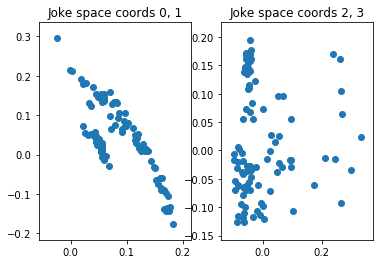

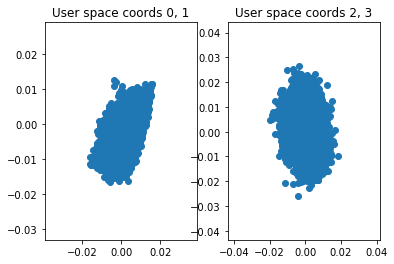

In [76]:
# looks interesting!
plt.figure()
plt.subplot(1, 2, 1)
plt.scatter(v[0, :], v[1, :])
plt.title("Joke space coords 0, 1")
plt.subplot(1, 2, 2)
plt.scatter(v[2, :], v[3, :])
plt.title("Joke space coords 2, 3")

# I have no idea
plt.figure()
plt.subplot(1, 2, 1)
plt.scatter(u[:, 0], u[:, 1])
plt.title("User space coords 0, 1")
plt.subplot(1, 2, 2)
plt.scatter(u[:, 2], u[:, 3])
plt.title("User space coords 2, 3")